<h2><center>Graduate Project - CSCI 6350</center></h2>
<h1><center>Comparing Deep Learning Transformers To Naive Bayes and Random Forest Models in the Context of Emotion Detection</center></h1>
<h3><center>Richard Hoehn</center></h3>
<h3><center>Middle Tennessee State University</center></h3>

In [1]:
# Imports of main Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# SKlearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


# BERT - Huggingface
from transformers import BertModel
from transformers import BertTokenizer
from transformers import BertForSequenceClassification


# PyTorch Libs
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torchmetrics import Accuracy
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim


# Lightning Libs - Primarilry for the Trainer()
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


# Plotting and Displaying Setup
%matplotlib inline
pd.set_option('display.max_columns', 500) # Allows for up to 500 columns to be displayed when viewing a dataframe
pd.set_option('display.max_info_columns', 250) # Allows for up to 250 columns to be displayed when viewing a dataframe as "info()"
plt.style.use('seaborn-v0_8') # A style that can be used for plots - see style refere nce above


# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

# Data Loading

In [2]:
# Load csv into dataframe
df =  pd.read_csv('pd_en_translated.csv', index_col = None, header=0)

# Display Some details of the Dataset
print("\n*** Emotion Tagged Sentences ***")
display(df.head(5))


*** Emotion Tagged Sentences ***


,emotion_en,sentence_en,emotion_de,sentence_de
0,sadness,"sorry mum, will treat you well from now on",Traurigkeit,"Entschuldigung, Mama, werde Sie von nun an gut..."
1,hate,i hate snoring. remind me if my future husband...,Ekel,Ich hasse es zu schnarchen.Erinnern Sie mich d...
2,surprise,"And I end up in privilege... Oh well, at least...",Überraschung,"Und ich lande im Privileg ... na ja, zumindest..."
3,worry,Tasha's really bad haircut. She's being treate...,Angst,Tasha ist wirklich schlechter Haarschnitt.Sie ...
4,sadness,I miss my mom.. &quot;May angels lead you in&...,Traurigkeit,Ich vermisse meine Mutter.


In [3]:
# Drop Columns Not Needed
df.drop(["emotion_de", "sentence_de"], axis=1, inplace=True)

## Plot Pie Chart of Emotion Distribution

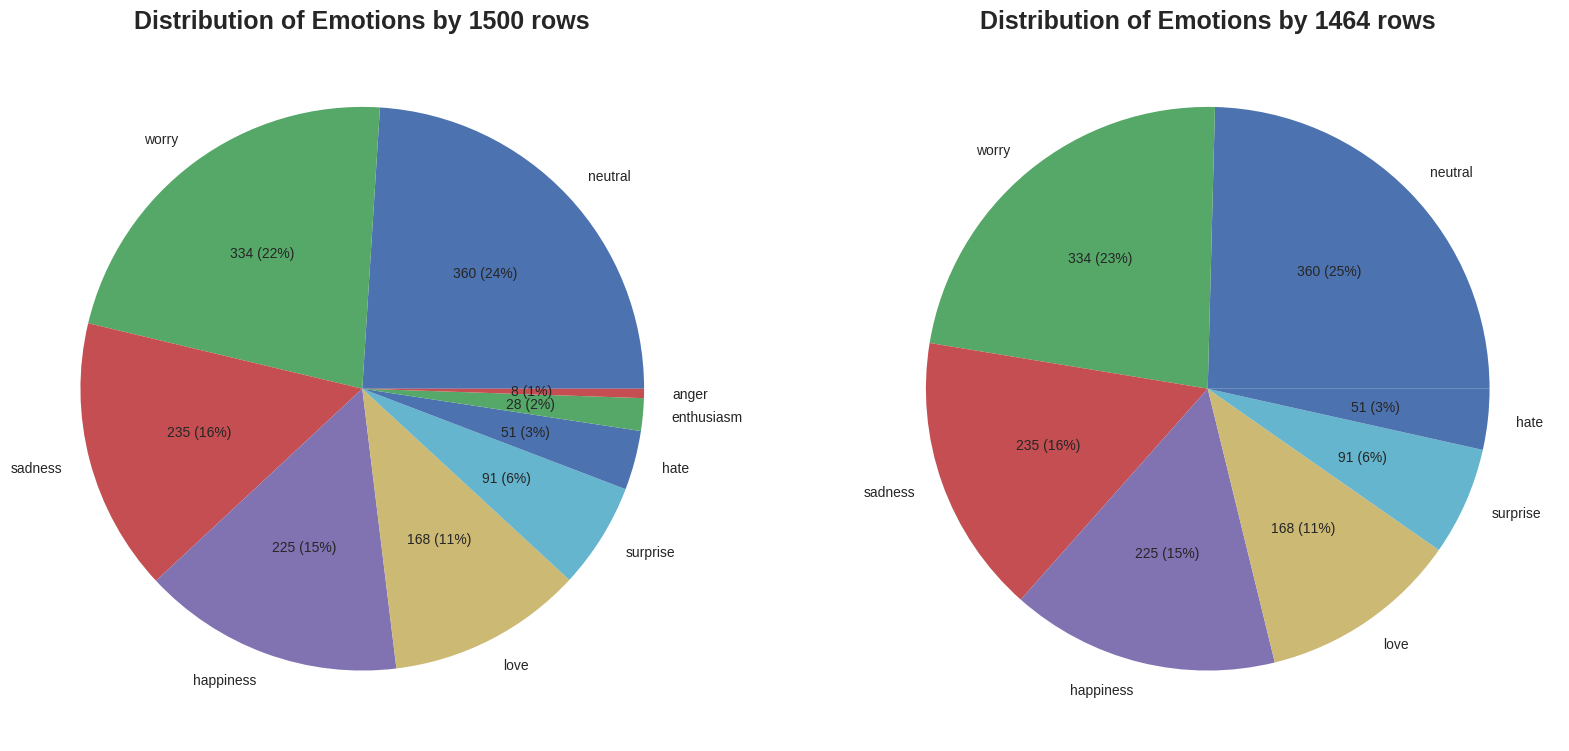

In [4]:
# Group by Emotions 
emotion_count = df["emotion_en"].value_counts()

# Make sure we use the entire width
plt.figure(figsize=(20, 10))


# Custom function to show both count and percentage on the pie chart
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d} ({p:.0f}%)'.format(p=pct,v=val)
    return my_format


# Group by Emotions 
emotion_count = df["emotion_en"].value_counts()

# First - Raw Pie Chart
plt.subplot(121)
plt.pie(emotion_count, 
        labels = emotion_count.index,
        autopct = autopct_format(emotion_count)
       )

# Setup Title
plt.title(f'Distribution of Emotions by {len(df)} rows', 
          fontweight='bold', 
          fontsize='18', 
          horizontalalignment='center')



# Remove rows where 'emotion_en' is 'anger' and 'enthusiasm'
df = df[df['emotion_en'] != 'anger']
df = df[df['emotion_en'] != 'enthusiasm']

# Group by Emotions 
emotion_count = df["emotion_en"].value_counts()

# Second - Updated Pie Chart
plt.subplot(122)
plt.pie(emotion_count, 
        labels = emotion_count.index,
        autopct = autopct_format(emotion_count)
       )

# Setup Title
plt.title(f'Distribution of Emotions by {len(df)} rows', 
          fontweight='bold', 
          fontsize='18', 
          horizontalalignment='center')

# Save & Show the Plot
plt.savefig('fig_distribution.png')
plt.show()

# Review Max Length and Disttibution of Sentence Counts

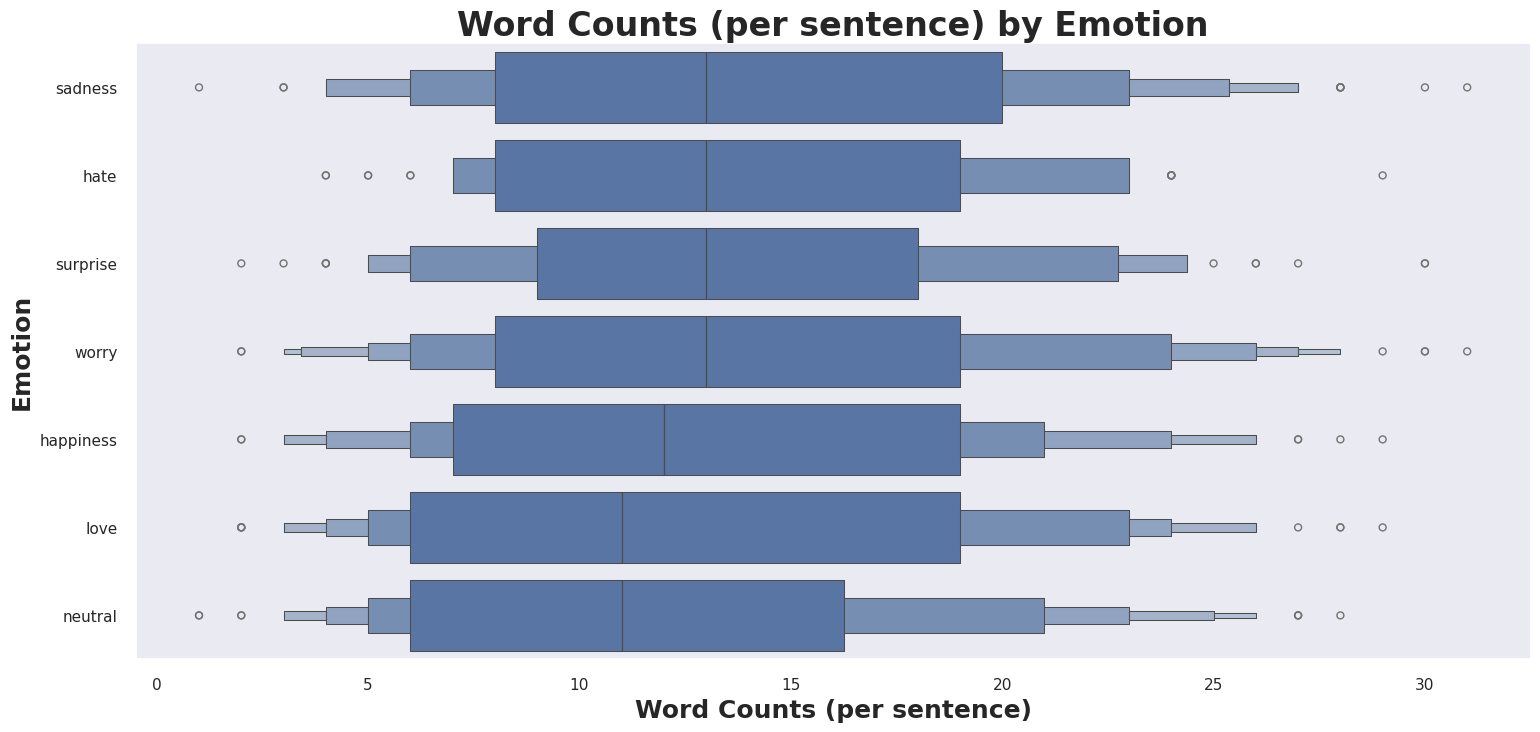

In [5]:
df["word_count"] = df["sentence_en"].str.split().apply(len)

# Setting the Style of Seaborn
sns.set(style='dark')

# Make sure we use the entire width
plt.figure(figsize=(18, 8))

sns.boxenplot(
    data = df, 
    x = "word_count",
    y = "emotion_en")

# Setup Title, and Axis Lables
plt.title('Word Counts (per sentence) by Emotion', 
          fontweight='bold', 
          fontsize='24', 
          horizontalalignment='center')

plt.xlabel('Word Counts (per sentence)', 
           fontweight='bold', 
           fontsize='18', 
           horizontalalignment='center')

plt.ylabel('Emotion', 
           fontweight='bold', 
           fontsize='18')


# Save & Show the Plot
plt.savefig('fig_word_counts.png')
plt.show()

# Label Encoding of Emotions

In [6]:
# Label Encoding the Emotions
label_encoder = LabelEncoder()
  
# Encode labels in column 'emotion_en'
df['label'] = label_encoder.fit_transform(df['emotion_en']) 

# Show Updated Dataframe
display(df.head(10))

,emotion_en,sentence_en,word_count,label
0,sadness,"sorry mum, will treat you well from now on",9,4
1,hate,i hate snoring. remind me if my future husband...,15,1
2,surprise,"And I end up in privilege... Oh well, at least...",15,5
3,worry,Tasha's really bad haircut. She's being treate...,18,6
4,sadness,I miss my mom.. &quot;May angels lead you in&...,9,4
5,surprise,@laurenceobrien Thank you xo,4,5
6,surprise,The chicken noodle soup I made for lunch to fe...,21,5
7,worry,Being dragged round Ikea this morning Bad times!,8,6
8,happiness,seniors done 5 more days!! woohoo!! going out...,11,0
9,worry,"...wait, I lied.",3,6


In [7]:
# Setup / Instantiate the Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

# Show Detail on the BERT Tokenizer
print(f'Vocab size: {tokenizer.vocab_size}')
print(f'Max length: {tokenizer.model_max_length}')
print(f'Tokenizer Model Input: {tokenizer.model_input_names}')

Vocab size: 30522
Max length: 512
Tokenizer Model Input: ['input_ids', 'token_type_ids', 'attention_mask']


# Encoding / Tokenization Stage

In [8]:
# Example of Tokenizer
print('Encoded text')
encoded_text = tokenizer("Hello World!", 
                         add_special_tokens = True, 
                         max_length = 10, 
                         truncation=True, 
                         padding=True)
print(encoded_text,'\n')

Encoded text
{'input_ids': [101, 7592, 2088, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]} 



In [9]:
# Set the maximum sequence length.
MAX_LEN = 64 # This is derived by the above details!
SEED = 42

# Create the Level and Sentence List (Arrays)
emotions  = df.emotion_en.values
sentences = df.sentence_en.values
labels    = df.label.values
tokens    = [ tokenizer(sent, add_special_tokens = True, max_length = MAX_LEN, truncation=True, pad_to_max_length = True) for sent in sentences ]

# Example Index - Just for Demo Info
IDX = 20

print("\nSentence:\n->", sentences[IDX])
print("\nTokens:\n->", tokens[IDX])
print("\nLabel:\n->", labels[IDX])
print("\nEmotion:\n->", emotions[IDX])

/opt/conda/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



Sentence:
-> @Desert_Star95 oh so you know how I feel then  Damn representative for bank of america tried to make it sound like I did it. What a b ...

Tokens:
-> {'input_ids': [101, 1030, 5532, 1035, 2732, 2683, 2629, 2821, 2061, 2017, 2113, 2129, 1045, 2514, 2059, 4365, 4387, 2005, 2924, 1997, 2637, 2699, 2000, 2191, 2009, 2614, 2066, 1045, 2106, 2009, 1012, 2054, 1037, 1038, 1012, 1012, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

Label:
-> 6

Emotion:
-> worry


# Split into a training set and a test set using a stratified k fold

In [10]:
# Get Classes
n_classes = len(df["label"].unique())
print(f"Unique Classes: {n_classes}")

# Settings
PCT_TRAIN = 0.8 # => 80%

X_train, X_test, y_train, y_test = train_test_split(tokens, 
                                                    labels, 
                                                    test_size=(1-PCT_TRAIN),
                                                    random_state=SEED, 
                                                    stratify=labels)


X_val, X_test, y_val, y_test = train_test_split(X_test, 
                                                y_test, 
                                                test_size=0.5, # Split in Half (50%)
                                                random_state=SEED, 
                                                stratify= y_test )

# Show Count Details - Small Dataset!!!
print(len(X_train))
print(len(y_train))
print(len(X_val))   
print(len(y_val)) 
print(len(X_test))   
print(len(y_test)) 

Unique Classes: 7
1171
1171
146
146
147
147


# Build Datasets into Tensors

In [11]:
# Create Tensors for Training and Testing

# Training Data
train_input_ids_tensors = torch.tensor([d['input_ids'] for d in X_train])
train_attention_mask_tensors = torch.tensor([d['attention_mask'] for d in X_train])
train_labels_tensors = torch.tensor(y_train)

# Validation Data
val_input_ids_tensors = torch.tensor([d['input_ids'] for d in X_val])
val_attention_mask_tensors = torch.tensor([d['attention_mask'] for d in X_val])
val_labels_tensors = torch.tensor(y_val)

# Test Data
test_input_ids_tensors = torch.tensor([d['input_ids'] for d in X_test])
test_attention_mask_tensors = torch.tensor([d['attention_mask'] for d in X_test])
test_labels_tensors = torch.tensor(y_test)


# Creating the DataLoaders for the Trainer()

In [12]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
BATCH_SIZE = 10
NUM_WORKERS = 3

train_data = TensorDataset(train_input_ids_tensors,
                           train_attention_mask_tensors,
                           train_labels_tensors)

train_dataloader = DataLoader(train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = True)

val_data = TensorDataset(val_input_ids_tensors,
                         val_attention_mask_tensors,
                         val_labels_tensors)

val_dataloader = DataLoader(val_data,
                            batch_size = BATCH_SIZE,
                            num_workers = NUM_WORKERS,
                            shuffle = False)

test_data = TensorDataset(test_input_ids_tensors,
                          test_attention_mask_tensors,
                          test_labels_tensors)

test_dataloader = DataLoader(test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = NUM_WORKERS,
                             shuffle = False)

# BERT Model Design
This model inherits from the `pl.LightningModule` to allow fro the `Trainer()` to  handle learing rate and early stopping.

In [13]:
class BertClassifier(pl.LightningModule):
    def __init__(self, n_classes: int, learning_rate:float):
        super().__init__()
        self.bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=n_classes)
        self.learning_rate = learning_rate
        self.accuracy = Accuracy(num_classes = n_classes, task='multiclass')


    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask, labels=labels)
        return output

    def predict(self, input_ids, attention_mask):
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            outputs = self.bert(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
            return probs

    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        output = self.forward(input_ids, attention_mask, labels)
        
        # Get Loss
        loss = output.loss
        self.log('train_loss', loss, on_step=False, on_epoch=True)

        # Get Acc
        logits = output.logits
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, labels)
        self.log('train_acc', acc, on_step=False, on_epoch=True)

        # Get Learing Rate (for Logging)
        lr = self.trainer.optimizers[0].param_groups[0]['lr']
        self.log('lr', lr, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        output = self.forward(input_ids, attention_mask, labels)
        
        # Get Loss
        loss = output.loss
        self.log('val_loss', loss, on_step=False, on_epoch=True)

        # Get Acc
        logits = output.logits
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, labels)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        
        return loss

    def test_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        output = self.forward(input_ids, attention_mask, labels)
        
        # Get Loss
        loss = output.loss
        self.log('test_loss', loss, on_step=False, on_epoch=True)

        # Get Acc
        logits = output.logits
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, labels)
        self.log('test_acc', acc, on_step=False, on_epoch=True)
        
        return loss

    def configure_optimizers(self):
        # Define Optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        # Define LR scheduler
        scheduler = {
            'scheduler': StepLR(optimizer, 
                                step_size = 1, # Drop Each Epoch
                                gamma = 0.95), # 5% Drop in LR
            'interval': 'epoch',  # or 'step' for step-wise
            'frequency': 2,
        }
        # Return the Optimizer and Scheduler in Dictionary List
        return [optimizer], [scheduler]



In [14]:
# Settings / Configurations
NUM_EPOCHS  = 10
NUM_CLASSES = n_classes
L_RATE      = 0.000005
LOG_DIR     = "logs"
LOG_NAME    = "Classifier"
ES_PATIENCE = 3


# Instantiate the Logger
csv_logger = CSVLogger(name = LOG_NAME, save_dir = LOG_DIR)


# Instantiate Model with Class Count
model = BertClassifier(n_classes = NUM_CLASSES, learning_rate = L_RATE)


# Initialize the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor = 'val_loss',    # Monitor validation loss for early stopping
    patience = ES_PATIENCE,  # Number of epochs to wait for improvement before stopping
    verbose = True,          # Print messages when stopping
    mode = 'min'             # The direction is automatically inferred if not set but it's good practice to include
)


# Setup Trainer with Logger Included
trainer = pl.Trainer(logger = csv_logger,                     
                     max_epochs = NUM_EPOCHS,
                     enable_progress_bar = True,
                     callbacks=[early_stopping])


# Start Training / Fine-Tuning the Model
trainer.fit(model, train_dataloader, val_dataloader)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                          | Params
-----------------------------------------------------------
0 | bert     | BertForSequenceClassification | 109 M 
1 | accuracy | MulticlassAccuracy            | 0     
-----------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.950   Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 1.779


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 1.705


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 1.653


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.141 >= min_delta = 0.0. New best score: 1.512


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.482


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1.482. Signaling Trainer to stop.


In [15]:
# Actual Model (no Trainer) to Predict!
pred_output = model.predict(test_input_ids_tensors, test_attention_mask_tensors)

# Show Tensor Output Probailities!
print(pred_output)


tensor([[0.6053, 0.0123, 0.2501,  ..., 0.0112, 0.0404, 0.0141],
        [0.1246, 0.0130, 0.0440,  ..., 0.0193, 0.0788, 0.0202],
        [0.0800, 0.0165, 0.0297,  ..., 0.0445, 0.0749, 0.0389],
        ...,
        [0.0145, 0.0898, 0.0216,  ..., 0.3688, 0.0394, 0.4252],
        [0.0450, 0.0356, 0.0283,  ..., 0.2031, 0.0684, 0.4416],
        [0.0132, 0.0727, 0.0182,  ..., 0.3354, 0.0376, 0.4805]])


In [16]:
# Get Predictions
y_preds = np.argmax(pred_output, axis=1)

# Get the F1-Score and Accuracy of the Correlation Matrix Details
f1 = f1_score(test_labels_tensors, y_preds, average="weighted")
acc = accuracy_score(test_labels_tensors, y_preds)

print(f"Acc: {acc}")
print(f"F1-Score: {f1}")
print("|")
print(f'Output Prediction:{y_preds.shape}')
print(f'Pred\n: {y_preds}')
print(f'Label\n: {test_labels_tensors}')

Acc: 0.38095238095238093
F1-Score: 0.3472112521017685
|
Output Prediction:torch.Size([147])
Pred
: tensor([0, 3, 3, 3, 3, 3, 0, 0, 6, 0, 2, 3, 0, 3, 3, 6, 6, 3, 3, 3, 6, 6, 0, 2,
        3, 3, 6, 6, 6, 0, 0, 0, 3, 6, 6, 3, 0, 3, 2, 6, 2, 6, 3, 3, 2, 0, 6, 3,
        6, 3, 3, 6, 3, 4, 6, 3, 3, 6, 0, 0, 3, 3, 3, 2, 0, 6, 0, 6, 6, 2, 0, 2,
        0, 2, 0, 6, 6, 6, 0, 6, 6, 6, 2, 6, 6, 4, 3, 6, 2, 3, 6, 3, 6, 6, 4, 0,
        6, 0, 3, 3, 6, 0, 3, 4, 6, 4, 6, 3, 4, 6, 6, 6, 6, 3, 0, 6, 3, 6, 3, 3,
        3, 6, 0, 6, 3, 3, 3, 6, 6, 6, 0, 6, 3, 0, 0, 6, 6, 6, 4, 3, 0, 0, 3, 3,
        6, 6, 6])
Label
: tensor([3, 3, 6, 3, 3, 6, 0, 2, 4, 0, 2, 3, 0, 5, 0, 4, 1, 3, 4, 3, 3, 5, 2, 0,
        2, 3, 2, 4, 4, 3, 0, 0, 2, 0, 1, 3, 0, 6, 0, 4, 5, 4, 3, 3, 0, 5, 0, 4,
        3, 3, 3, 2, 6, 0, 6, 2, 3, 4, 2, 3, 3, 0, 3, 2, 2, 5, 6, 3, 6, 2, 3, 0,
        6, 2, 0, 1, 4, 0, 6, 6, 6, 6, 4, 3, 6, 4, 0, 6, 2, 2, 4, 6, 4, 6, 6, 5,
        5, 6, 4, 3, 6, 6, 3, 2, 3, 4, 4, 3, 6, 1, 3, 3, 4, 0, 3, 6, 3, 4, 3

[[ 9  0  4  5  1  0  3]
 [ 0  0  0  0  0  0  5]
 [ 4  0  5  4  1  0  3]
 [ 5  0  0 23  0  0  8]
 [ 1  0  1  4  3  0 15]
 [ 3  0  1  1  0  0  4]
 [ 7  0  0  9  2  0 16]]



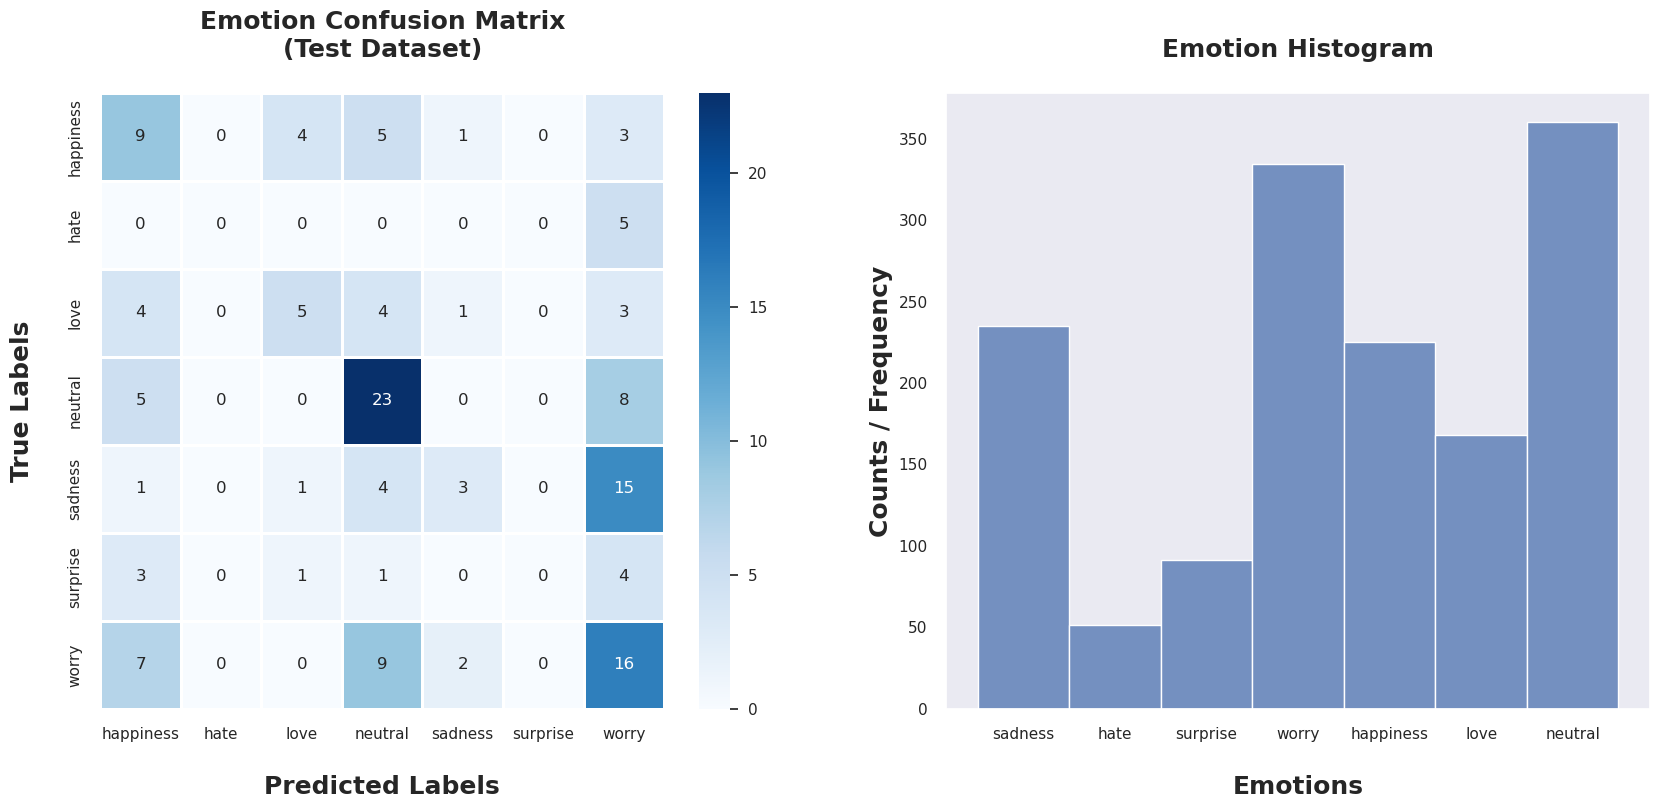

In [17]:
# Create Confusion Matrix
conf_matrix = confusion_matrix(test_labels_tensors, y_preds)

# Show Details
print(conf_matrix)
print()

# Get Class Names based on teh Label Idx
sorted_df = df.sort_values(by='label').drop_duplicates(subset=['emotion_en'])
class_names = sorted_df['emotion_en'].tolist()
# Something like this: class_names = ['Happiness', 'Hate', 'Love', 'Neutral', 'Sadness', 'Surprise', 'Worry']

plt.figure(figsize=(20, 8))

# Create Seaborn Heatmap for Display Confusion Matrix
plt.subplot(121)
sns.heatmap(conf_matrix, 
            annot=True,
            fmt='g',
            cmap='Blues',
            linewidth=1,
            xticklabels=class_names,
            yticklabels=class_names)


# Setup Title and Axis Lables
plt.title('Emotion Confusion Matrix\n(Test Dataset)\n', 
          fontweight='bold', 
          fontsize='18', 
          horizontalalignment='center')

plt.xlabel('\nPredicted Labels', 
           fontweight='bold', 
           fontsize='18', 
           horizontalalignment='center')

plt.ylabel('True Labels\n', 
           fontweight='bold', 
           fontsize='18')


plt.subplot(122)
sns.histplot(data=df, x='emotion_en')

# Setup Title and Axis Lables
plt.title('Emotion Histogram\n', 
          fontweight='bold', 
          fontsize='18', 
          horizontalalignment='center')

plt.xlabel('\nEmotions', 
           fontweight='bold', 
           fontsize='18', 
           horizontalalignment='center')

plt.ylabel('Counts / Frequency', 
           fontweight='bold', 
           fontsize='18')


# Save & Show the Plot
plt.savefig('fig_confusion_matrix.png')
plt.show()

# Display Validation & Testing Results

In [18]:
trainer.validate(model, dataloaders=val_dataloader)
trainer.test(model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.39726027846336365    │
│         val_loss          │    1.5434670448303223     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.380952388048172     │
│         test_loss         │    1.7607795000076294     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.7607795000076294, 'test_acc': 0.380952388048172}]

# Plot Training Parameters

In [19]:
results = pd.read_csv(csv_logger.log_dir + "/metrics.csv")
results

,val_loss,step,epoch,val_acc,train_loss,lr,train_acc,test_loss,test_acc
0,1.778817,117,0,0.294521,NaN,NaN,NaN,NaN,NaN
1,NaN,117,0,NaN,1.853640,0.000005,0.236550,NaN,NaN
2,1.704656,235,1,0.328767,NaN,NaN,NaN,NaN,NaN
3,NaN,235,1,NaN,1.742712,0.000005,0.316823,NaN,NaN
4,1.653244,353,2,0.417808,NaN,NaN,NaN,NaN,NaN
5,NaN,353,2,NaN,1.625816,0.000005,0.381725,NaN,NaN
6,1.511819,471,3,0.397260,NaN,NaN,NaN,NaN,NaN
7,NaN,471,3,NaN,1.509168,0.000005,0.444065,NaN,NaN
8,1.481664,589,4,0.390411,NaN,NaN,NaN,NaN,NaN
9,NaN,589,4,NaN,1.391266,0.000005,0.491887,NaN,NaN


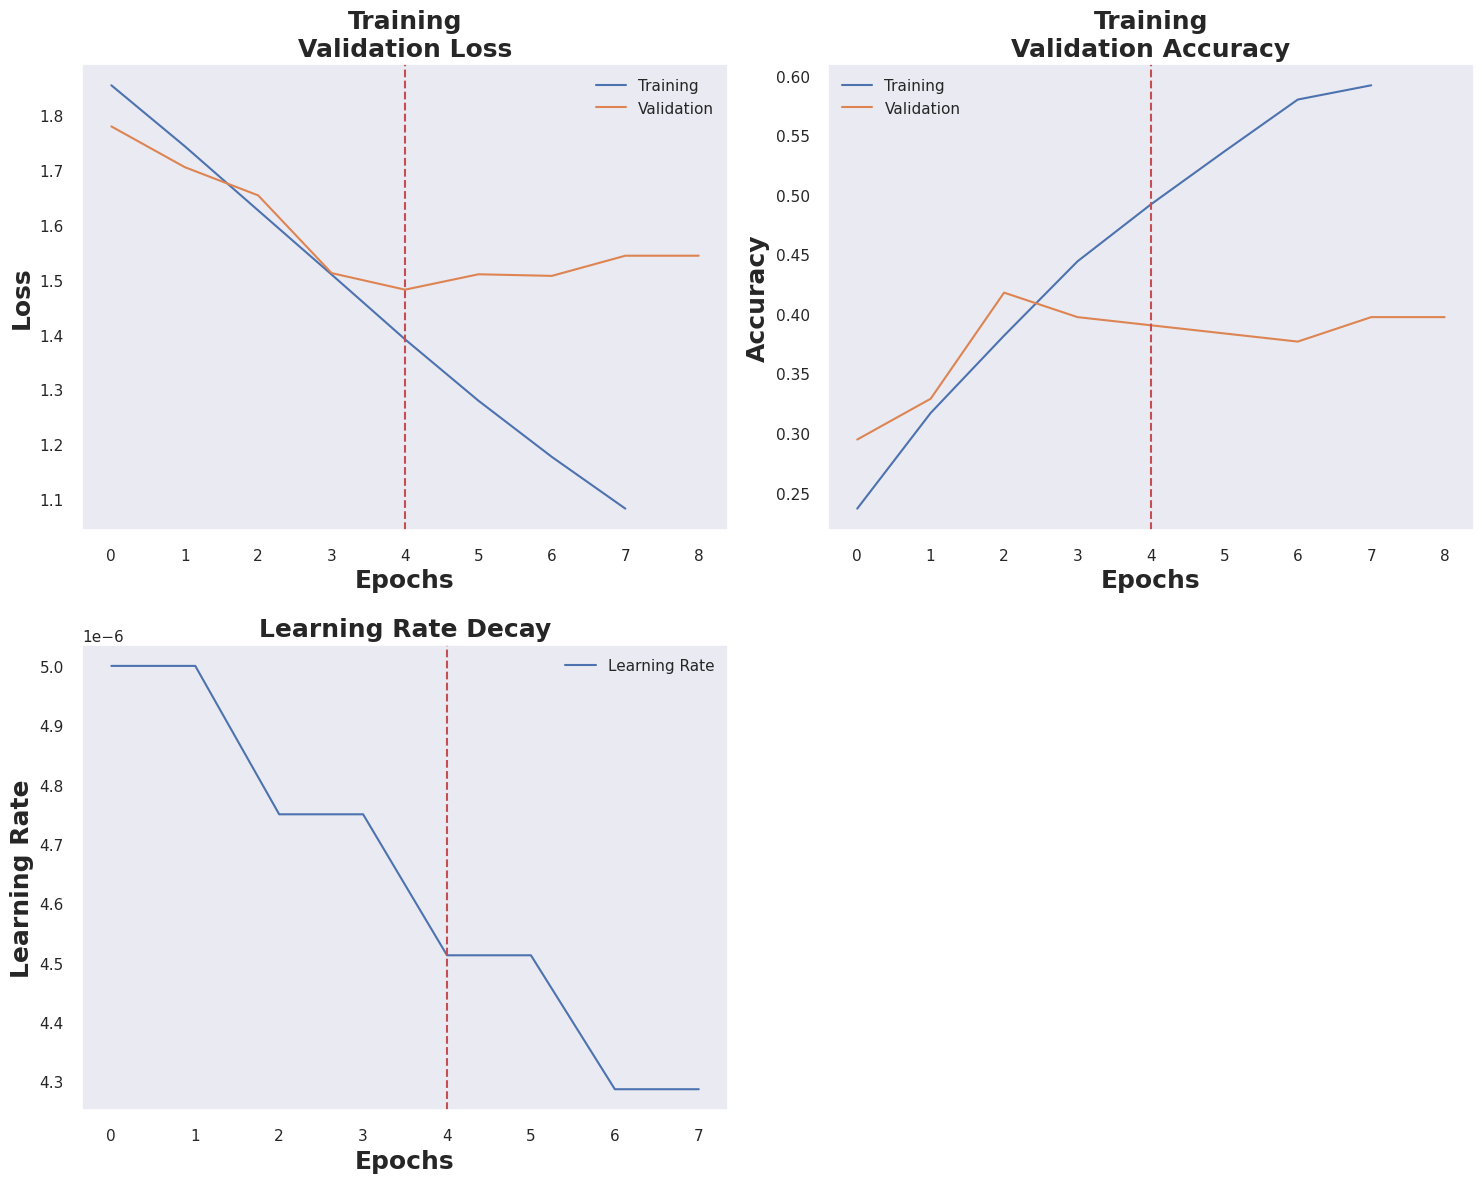

In [20]:
# Set Chart Sizing
plt.figure(figsize=(15, 12))

# Best EPOCH
BEST_EPOCH = 4

# Loss Plot
plt.subplot(221)
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")

plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))],
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))],
         label="Validation")

plt.legend()
plt.title('Training\nValidation Loss', 
          fontweight='bold', 
          fontsize='18', 
          horizontalalignment='center')

plt.xlabel('Epochs', 
           fontweight='bold', 
           fontsize='18', 
           horizontalalignment='center')

plt.ylabel('Loss', 
           fontweight='bold', 
           fontsize='18')

# Show Epoch that was best!
plt.axvline(x=BEST_EPOCH, color='r', linestyle='--')

# Accuracy Plot
plt.subplot(222)
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_acc"]))],
         results["train_acc"][np.logical_not(np.isnan(results["train_acc"]))],
         label="Training")

plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_acc"]))],
         results["val_acc"][np.logical_not(np.isnan(results["val_acc"]))],
         label="Validation")

plt.legend()
plt.title('Training\nValidation Accuracy', 
          fontweight='bold', 
          fontsize='18', 
          horizontalalignment='center')

plt.xlabel('Epochs', 
           fontweight='bold', 
           fontsize='18', 
           horizontalalignment='center')

plt.ylabel('Accuracy', 
           fontweight='bold', 
           fontsize='18')

# Show Epoch that was best!
plt.axvline(x=BEST_EPOCH, color='r', linestyle='--')


# LR Plot
plt.subplot(223)
plt.plot(results["epoch"][np.logical_not(np.isnan(results["lr"]))],
         results["lr"][np.logical_not(np.isnan(results["lr"]))],
         label="Learning Rate")

plt.legend()
plt.title('Learning Rate Decay', 
          fontweight='bold', 
          fontsize='18', 
          horizontalalignment='center')

plt.xlabel('Epochs', 
           fontweight='bold', 
           fontsize='18', 
           horizontalalignment='center')

plt.ylabel('Learning Rate', 
           fontweight='bold', 
           fontsize='18')

# Show Epoch that was best!
plt.axvline(x=BEST_EPOCH, color='r', linestyle='--')

plt.tight_layout(h_pad=1.5)

# Save & Show the Plot
plt.savefig('fig_training.png')
plt.show()